In [181]:
import pandas as pd
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [182]:
df_envi_inter = pd.read_csv("../../../DataSet/Envi/envi.csv")
df_envi_inter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    169 non-null    object
 1   Envi    169 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [183]:
df_envi_inter

,Date,Envi
0,04/01/2015,44562
1,11/01/2015,38112
2,18/01/2015,50355
3,25/01/2015,51922
4,01/02/2015,67496
...,...,...
164,25/02/2018,42116
165,04/03/2018,44454
166,11/03/2018,28399
167,18/03/2018,49145


In [184]:
df_envi_inter["Date"] = pd.to_datetime(df_envi_inter["Date"], format="%d/%m/%Y")
df_envi_inter.sort_values(by="Date", inplace=True)
df_envi_inter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    169 non-null    datetime64[ns]
 1   Envi    169 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


In [185]:
def findBestRandomState(r,t, x, y):
    random = 0
    a = 1000000

    model = RegressorChain(GradientBoostingRegressor())
    for _ in range(r,t):
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=_)
        model.fit(x_train, y_train)

        y_predict = model.predict(x_test)
        if (buff := mean_absolute_error(y_test, y_predict)) < a:
            a = buff
            random = _
    print(a, random)

Function Create X Sequence to Prdict 1

In [186]:
def createSequenceToOneDataSet(r, data:pd.DataFrame):  # Create Sequence DataSet
    df = data.copy()
    i = 1
    
    while i < r:
        df[f'x{i}'] = df['Envi'].shift(-i)
        i += 1

    if i == r:
        df['y'] = df['Envi'].shift(-i)

    df = df.dropna(axis=0)
    return df

DataSet for Predict y by Use Sequence X

In [187]:
df = createSequenceToOneDataSet(5, df_envi_inter)
df

,Date,Envi,x1,x2,x3,x4,y
0,2015-01-04,44562,38112.0,50355.0,51922.0,67496.0,54229.0
1,2015-01-11,38112,50355.0,51922.0,67496.0,54229.0,41548.0
2,2015-01-18,50355,51922.0,67496.0,54229.0,41548.0,50872.0
3,2015-01-25,51922,67496.0,54229.0,41548.0,50872.0,40578.0
4,2015-02-01,67496,54229.0,41548.0,50872.0,40578.0,46025.0
...,...,...,...,...,...,...,...
159,2018-01-21,49711,66654.0,57481.0,48309.0,39773.0,42116.0
160,2018-01-28,66654,57481.0,48309.0,39773.0,42116.0,44454.0
161,2018-02-04,57481,48309.0,39773.0,42116.0,44454.0,28399.0
162,2018-02-11,48309,39773.0,42116.0,44454.0,28399.0,49145.0


In [188]:
# x = df[['Envi','x1','x2','x3','x4']].values # Pasing Df_x to x
# y = df['y'].values                          # Pasing Df_y to y

x = np.array(df.drop(columns='y'))

y = np.array(df.drop(columns=['Envi','x1','x2','x3','x4']))
# scaler = StandardScaler()
# scaler.fit(x)
# x = scaler.transform(x)
# scaler.fit(y.reshape(-1,1))
# y = scaler.transform(y.reshape(-1,1))



# findBestRandomState(100000,200000,x, y)
# seed 195043 MAE: 3452.587947630313
# seed 12049 MAE: 3531.341997248567
# seed 9930 MAE: 3576.2944849569312
# seed 607 MAE: 4145.711673614879

x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2,random_state=12049)

x_train = np.array(sorted(x_train, key=lambda x: x[0]))
x_test = np.array(sorted(x_test, key=lambda x: x[0]))
y_train = np.array(sorted(y_train, key=lambda x: x[0]))
y_test = np.array(sorted(y_test, key=lambda x: x[0]))


In [189]:
ml = RegressorChain(GradientBoostingRegressor(learning_rate=0.0329,criterion='friedman_mse',max_leaf_nodes=16))
ml.fit(x_train[:, 1:], y_train[:, 1:])

RegressorChain(base_estimator=GradientBoostingRegressor(learning_rate=0.0329,
                                                        max_leaf_nodes=16))

In [190]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [191]:
y_predict = ml.predict(x_test[:, 1:])

print(f"Mean Absolute Error: {mean_absolute_error(y_test[:, 1:], y_predict)}")
print(f"The Mean Square Error: {mean_squared_error(y_test[:, 1:], y_predict)}")
print(f"The R2 score: {r2_score(y_test[:, 1:], y_predict)}")

Mean Absolute Error: 3101.0714844748222
The Mean Square Error: 15075941.362702837
The R2 score: 0.6985921156685517


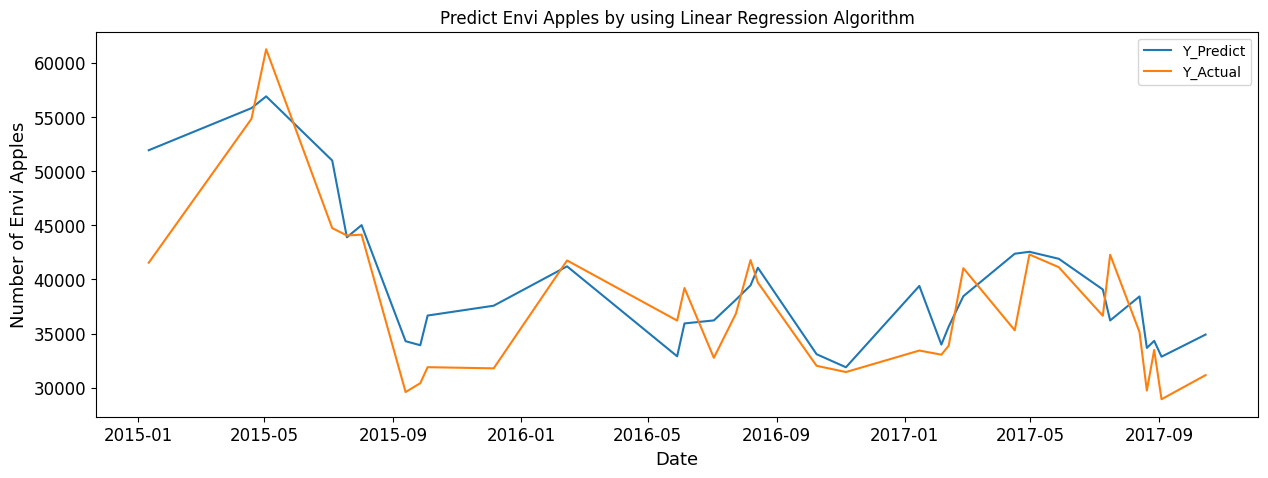

In [192]:
plt.figure(figsize=(15, 5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(x_test[:, :1], y_predict, label="Y_Predict")
plt.plot(x_test[:,:1], y_test[:, 1:], label="Y_Actual")
plt.xlabel("Date", fontsize=13)
plt.ylabel("Number of Envi Apples", fontsize=13)
plt.title("Predict Envi Apples by using Linear Regression Algorithm")
plt.legend()
plt.show()